## Configuration

In [50]:
%load_ext autoreload
%autoreload 2

import os, time, pytz, datetime
import optuna
import numpy as np
import pandas as pd
import polars as pl
import xgboost as xgb
import lightgbm as lgb
import warnings

warnings.filterwarnings("ignore")

from src.utils import evaluate_hitrate_at_3, make_submission
from src.feature import feature_engineering, feature_selection
from src.plot import plot_hitrate_at_k, plot_ndcg_curve
from src.data import split_dataset, split_dataset_leg
from src.params import get_hyper_params
from src.utils import TRAIN_VAL_SIZE

# Configurations
MODEL = "xgboost"
# Switch to True when training on full dataset
FULL = True
RANDOM_STATE = 42

try:
    TIME_TAG
except NameError:
    tz = pytz.timezone("Asia/Shanghai")
    TIME_TAG = datetime.datetime.now(tz).strftime("%Y%m%d%H%M%S")
print("Time Tag:", TIME_TAG)

DATA_DIR = "./data"
MODEL_DIR = "model"
SUBMIT_DIR = "submission"

# Create dir
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(SUBMIT_DIR, exist_ok=True)

# Feature engineered df
feat_df_path = "feateng_full.parquet" if FULL else "feateng_not_full.parquet"
feat_df_path = os.path.join(DATA_DIR, feat_df_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Time Tag: 20250814064056


## Data Processing

In [51]:
train = pl.read_parquet(os.path.join(DATA_DIR, "train.parquet")).drop(
    "__index_level_0__"
)
test = (
    pl.read_parquet(os.path.join(DATA_DIR, "test.parquet"))
    .drop("__index_level_0__")
    .with_columns(pl.lit(0, dtype=pl.Int64).alias("selected"))
)

val = train.slice(TRAIN_VAL_SIZE, train.height - TRAIN_VAL_SIZE)

df = pl.concat((train, test))


print("Successfully load parquet files!")

Successfully load parquet files!


## Feature Engineering

In [52]:
df = pl.read_parquet(feat_df_path)

## Feature Selection

In [53]:
X, y, groups, cat_features_final, num_features_final = feature_selection(df, "one")

Using 111 features (57 categorical, 54 numerical)


## Train-Val-Test Split

In [54]:
dtrain, dval, dtest, dfull, _, _, _, X_va, y_va, groups_va, X_te, mask_va, mask_te = (
    split_dataset_leg(train, X, y, groups, cat_features_final, 1)
)
print("Data split finished!")

Data split finished!


In [55]:
del train, df, X
if not FULL:
    del dtest, dfull, X_te
else:
    del dtrain
import gc

gc.collect()

10860

## Tune hyperparams

In [56]:
import joblib
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler

os.makedirs("optuna", exist_ok=True)
STUDY_FILENAME = f"optuna/{TIME_TAG}.pkl"


def load_or_create_study():
    try:
        study = joblib.load(STUDY_FILENAME)
        print(f"Loaded study from {STUDY_FILENAME}")
    except FileNotFoundError:
        study = optuna.create_study(
            direction="maximize",
            sampler=TPESampler(seed=RANDOM_STATE),
            pruner=SuccessiveHalvingPruner(),
        )
        print("Created new study")
    return study


def save_study(study):
    joblib.dump(study, STUDY_FILENAME)
    print(f"Saved study to {STUDY_FILENAME}")

In [57]:
def xgb_objective(trial):

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "max_depth": trial.suggest_int("max_depth", 8, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 5, 30),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 0.8),
        "gamma": trial.suggest_float("gamma", 1, 10),
        "lambda": trial.suggest_float("lambda", 1, 100, log=True),
        "alpha": trial.suggest_float("alpha", 1e-2, 100, log=True),
        "sampling_method": trial.suggest_categorical(
            "sampling_method", ["uniform", "gradient_based"]
        ),
        "objective": "rank:ndcg",
        "eval_metric": "ndcg@3",
        "seed": RANDOM_STATE,
        "n_jobs": 12,
        "device": "cuda",
        "tree_method": "gpu_hist",
    }

    num_boost_round = trial.suggest_int("num_boost_round", 500, 1500)

    evals_result = {}
    model = xgb.train(
        params,
        dtrain if not FULL else dfull,
        num_boost_round=num_boost_round,
        evals=[(dtrain, "train"), (dval, "val")] if not FULL else [(dfull, "train")],
        early_stopping_rounds=100,
        verbose_eval=150,
        maximize=True,
        evals_result=evals_result,
    )

    ndcg = model.best_score
    trial.set_user_attr("best_ndcg@3", ndcg)

    return ndcg

In [58]:
# study = load_or_create_study()
# n_trials = 50
# for _ in range(n_trials):
#     study.optimize(xgb_objective, n_trials=1)
#     save_study(study)

# best_params = study.best_params
# best_params.update(
#     {
#         "objective": "rank:ndcg",
#         "eval_metric": "ndcg@3",
#         "seed": RANDOM_STATE,
#         "n_jobs": 6,
#         "device": "cuda",
#         "tree_method": "gpu_hist",
#     }
# )

In [59]:
best_params = get_hyper_params(MODEL, "one")
print("Best params:", best_params)

Best params: {'learning_rate': 0.04343187744940666, 'max_depth': 12, 'min_child_weight': 19, 'subsample': 0.8248294575009643, 'colsample_bytree': 0.7459686208274133, 'gamma': 5.062846713760882, 'lambda': 9.609163120649246, 'alpha': 0.08096494777196246, 'sampling_method': 'uniform', 'num_boost_round': 500, 'objective': 'rank:ndcg', 'eval_metric': 'ndcg@3', 'seed': 42, 'n_jobs': 32, 'device': 'cuda', 'tree_method': 'gpu_hist'}


## Model Training

In [60]:
print(f"Training final {MODEL} model...")
evals_result = {}
model = xgb.train(
    best_params,
    dtrain if not FULL else dfull,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dval, "val")] if not FULL else [(dfull, "train")],
    verbose_eval=50,
    maximize=True,
    evals_result=evals_result,
)

Training final xgboost model...
[0]	train-ndcg@3:0.43838
[50]	train-ndcg@3:0.65951
[100]	train-ndcg@3:0.71085
[150]	train-ndcg@3:0.74251
[200]	train-ndcg@3:0.76177
[250]	train-ndcg@3:0.77353
[300]	train-ndcg@3:0.78012
[350]	train-ndcg@3:0.78451
[400]	train-ndcg@3:0.78824
[450]	train-ndcg@3:0.79104
[499]	train-ndcg@3:0.79327


In [61]:
# Save model
if FULL:
    model_path = os.path.join(MODEL_DIR, f"{MODEL}_{TIME_TAG}.json")
    model.save_model(model_path)
    print(f"Model saved to: {model_path}")

Model saved to: model/xgboost_20250814064056.json


In [62]:
# Evaluate
va_preds = evaluate_hitrate_at_3(
    val.filter(mask_va), dval, y_va, groups_va, model, True
)

shape: (5, 4)
┌──────────┬─────────────────────────────────┬──────────┬────────────┐
│ Id       ┆ ranker_id                       ┆ selected ┆ pred_score │
│ ---      ┆ ---                             ┆ ---      ┆ ---        │
│ i64      ┆ str                             ┆ i32      ┆ f32        │
╞══════════╪═════════════════════════════════╪══════════╪════════════╡
│ 16487352 ┆ 0ab8aa6bd4b344efb94bdf4b814f10… ┆ 5        ┆ 0.112545   │
│ 16487353 ┆ 0ab8aa6bd4b344efb94bdf4b814f10… ┆ 3        ┆ 0.291269   │
│ 16487354 ┆ 0ab8aa6bd4b344efb94bdf4b814f10… ┆ 10       ┆ -0.783661  │
│ 16487355 ┆ 0ab8aa6bd4b344efb94bdf4b814f10… ┆ 7        ┆ -0.068556  │
│ 16487356 ┆ 0ab8aa6bd4b344efb94bdf4b814f10… ┆ 1        ┆ 0.443718   │
└──────────┴─────────────────────────────────┴──────────┴────────────┘
shape: (5, 3)
┌──────────┬─────────────────────────────────┬──────────┐
│ Id       ┆ ranker_id                       ┆ selected │
│ ---      ┆ ---                             ┆ ---      │
│ i64      ┆ str 

In [63]:
importance = model.get_score(importance_type="gain")
importance_df = pl.DataFrame(
    [{"feature": k, "importance": v} for k, v in importance.items()]
).sort("importance", descending=bool(1))

print(importance_df.to_pandas().to_string())

                                                   feature   importance
0                                     is_min_segments_leg0  2103.876709
1                                           is_direct_leg0   229.858551
2                                            free_exchange   131.893570
3                                 is_direct_cheapest_legs0    84.978493
4                                  legs0_all_cabin_level_1    78.846527
5                                   legs0_is_cross_country    62.599846
6                                    legs0_max_cabin_level    58.721413
7                                          n_segments_leg0    57.854420
8                                      is_cheaper_than_avg    52.982193
9                                   pricingInfo_isAccessTP    50.337631
10                                    rank_interaction_mul    49.181988
11                                        is_popular_route    46.012661
12                              legs0_segments0_cabinClass    39

## Error analysis and Visualization

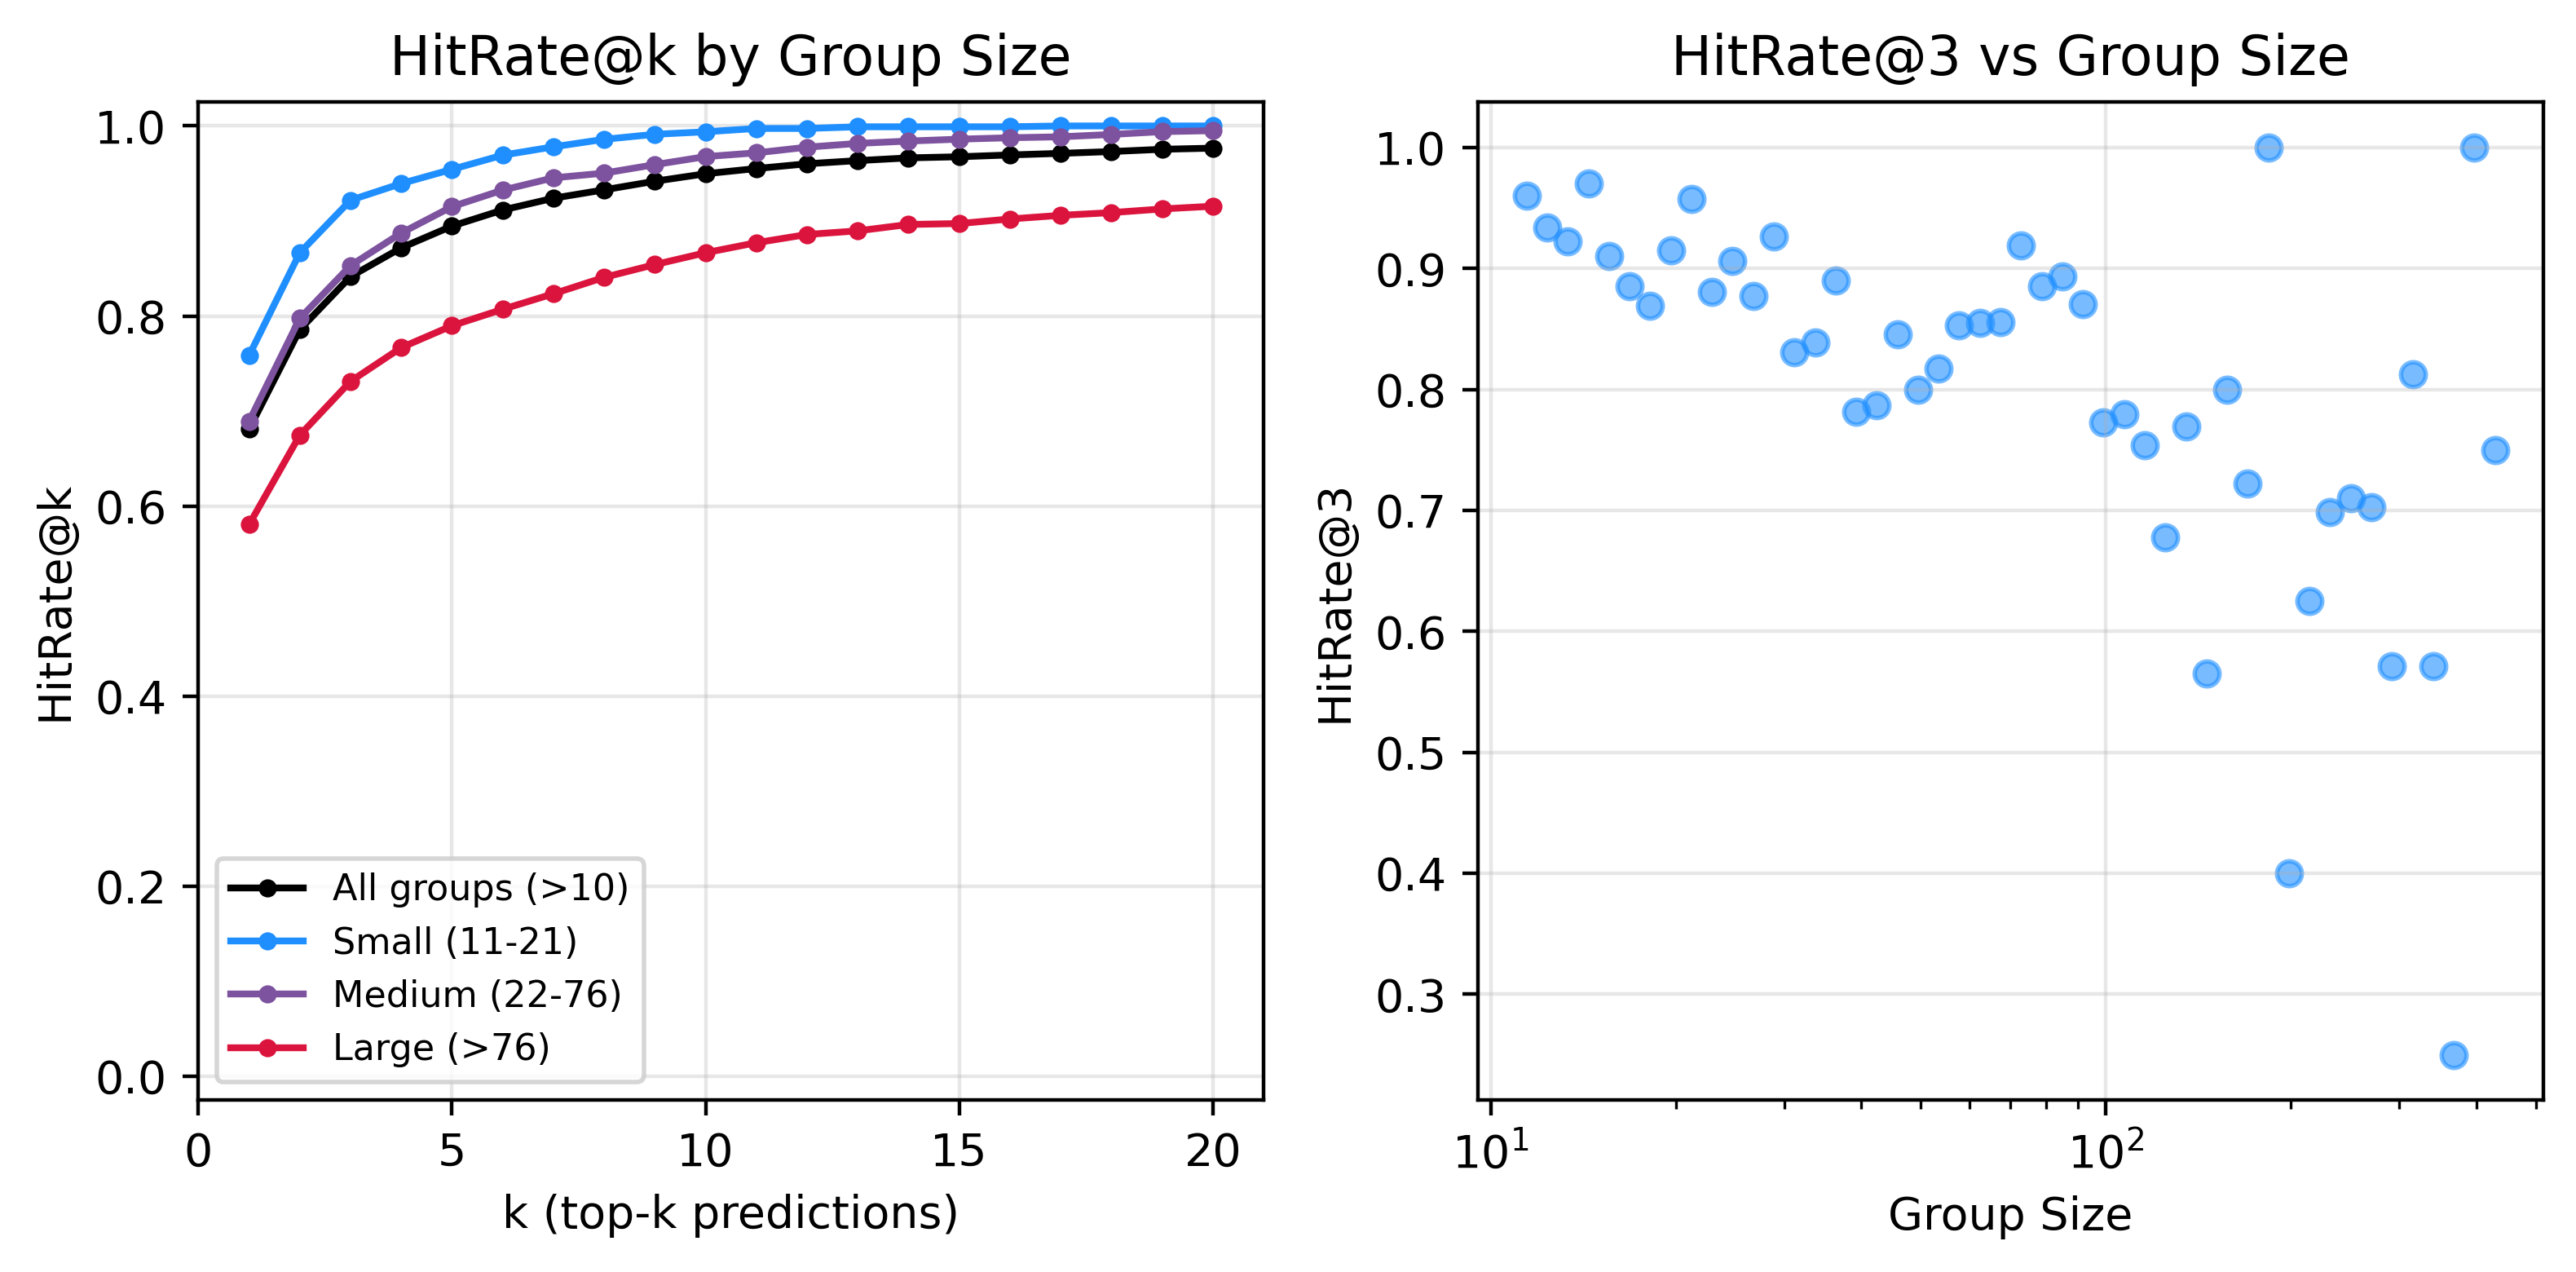

In [64]:
curves = plot_hitrate_at_k(groups_va, va_preds, y_va)

In [65]:
# Summary
print(f"HitRate@1: {curves['All groups (>10)'][0]:.5f}")
print(f"HitRate@3: {curves['All groups (>10)'][2]:.5f}")
print(f"HitRate@4: {curves['All groups (>10)'][3]:.5f}")
print(f"HitRate@5: {curves['All groups (>10)'][4]:.5f}")
print(f"HitRate@6: {curves['All groups (>10)'][5]:.5f}")
print(f"HitRate@10: {curves['All groups (>10)'][9]:.5f}")
print(f"HitRate@20: {curves['All groups (>10)'][19]:.5f}")

HitRate@1: 0.68112
HitRate@3: 0.84152
HitRate@4: 0.87178
HitRate@5: 0.89466
HitRate@6: 0.91158
HitRate@10: 0.94971
HitRate@20: 0.97664


## Submission

In [66]:
if FULL:
    submission_path = os.path.join(SUBMIT_DIR, f"submission_{TIME_TAG}.parquet")
    score_path = os.path.join(SUBMIT_DIR, "score", f"{TIME_TAG}.parquet")
    make_submission(test.filter(mask_te), dtest, model, submission_path, rerank=True)
    make_submission(test.filter(mask_te), dtest, model, score_path, True, True)

shape: (5, 4)
┌──────────┬─────────────────────────────────┬──────────┬────────────┐
│ Id       ┆ ranker_id                       ┆ selected ┆ pred_score │
│ ---      ┆ ---                             ┆ ---      ┆ ---        │
│ i64      ┆ str                             ┆ i32      ┆ f32        │
╞══════════╪═════════════════════════════════╪══════════╪════════════╡
│ 18145792 ┆ 8c387f33dc824a89ba7a6f2cb5908e… ┆ 24       ┆ -0.75327   │
│ 18145793 ┆ 8c387f33dc824a89ba7a6f2cb5908e… ┆ 21       ┆ -0.610881  │
│ 18145794 ┆ 8c387f33dc824a89ba7a6f2cb5908e… ┆ 35       ┆ -1.266594  │
│ 18145795 ┆ 8c387f33dc824a89ba7a6f2cb5908e… ┆ 30       ┆ -1.062981  │
│ 18145796 ┆ 8c387f33dc824a89ba7a6f2cb5908e… ┆ 31       ┆ -1.077987  │
└──────────┴─────────────────────────────────┴──────────┴────────────┘
shape: (5, 3)
┌──────────┬─────────────────────────────────┬──────────┐
│ Id       ┆ ranker_id                       ┆ selected │
│ ---      ┆ ---                             ┆ ---      │
│ i64      ┆ str 

In [67]:
# !kaggle competitions submit -c aeroclub-recsys-2025 -f {submission_file} -m {TIME_TAG}